In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
customers = pd.read_csv("/content/Customers.csv")
products = pd.read_csv("/content/Products.csv")
transactions = pd.read_csv("/content/Transactions.csv")

**Customer Segmentation / Clustering**

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# Merge transactions with customers and products
merged = transactions.merge(customers, on="CustomerID").merge(products, on="ProductID")

# Aggregate data by customer and product
customer_product_matrix = merged.pivot_table(
    index="CustomerID", columns="ProductID", values="Quantity", fill_value=0
)

# Compute cosine similarity
similarity_matrix = cosine_similarity(customer_product_matrix)


In [5]:
import numpy as np

# Get top 3 similar customers for each customer
similarity_df = pd.DataFrame(similarity_matrix, index=customer_product_matrix.index, columns=customer_product_matrix.index)

lookalikes = {}
for customer_id in similarity_df.index:
    similar_customers = similarity_df[customer_id].sort_values(ascending=False).iloc[1:4]
    lookalikes[customer_id] = list(zip(similar_customers.index, similar_customers.values))

# Save to CSV
import csv
with open("FirstName_LastName_Lookalike.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["CustomerID", "SimilarCustomers"])
    for key, value in lookalikes.items():
        writer.writerow([key, value])


Prepare Data for Clustering

In [6]:
from sklearn.preprocessing import StandardScaler

# Combine customer profile and transaction data
customer_summary = merged.groupby("CustomerID").agg({
    "TotalValue": "sum",
    "Quantity": "sum",
    "Region": "nunique"
}).reset_index()

# Encode categorical data and scale numerical data
customer_summary = pd.get_dummies(customer_summary, columns=["Region"])
scaler = StandardScaler()
customer_summary_scaled = scaler.fit_transform(customer_summary.drop(columns=["CustomerID"]))


Apply Clustering Algorithm

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
customer_summary["Cluster"] = kmeans.fit_predict(customer_summary_scaled)

# Calculate DB Index
db_index = davies_bouldin_score(customer_summary_scaled, customer_summary["Cluster"])
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.72127971818163


Visualize Clusters

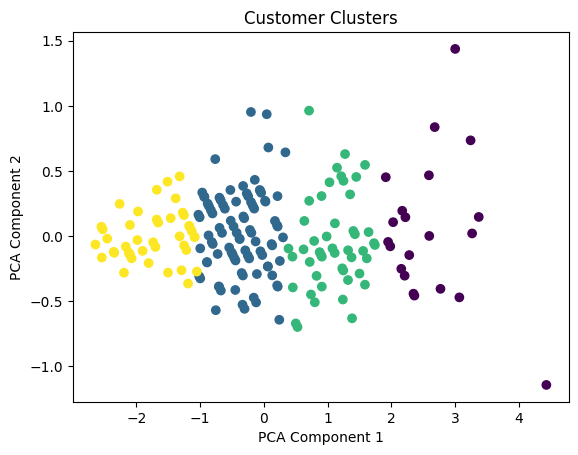

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
customer_summary_pca = pca.fit_transform(customer_summary_scaled)

plt.scatter(customer_summary_pca[:, 0], customer_summary_pca[:, 1], c=customer_summary["Cluster"])
plt.title("Customer Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()
